In [1]:
import mido # easy to use python MIDI library
import numpy as np # linear algebra
import os # accessing directory structure
import time
from mido import MidiFile, MidiTrack, Message
from IPython.display import Audio, clear_output

In [2]:
os.listdir()

['new_song.mid',
 '.ipynb_checkpoints',
 'start.ipynb',
 'generator.h5',
 'generator_weight.h5',
 'preprocess_data.npy',
 'discriminator_weight.h5',
 'blues']

In [3]:
"""
paths = []
songs = []
#append every filepath in the blues folder to paths[]
for r, d, f in os.walk("./blues"):
    for file in f:
        if '.mid' in file:
            paths.append(os.path.join(r, file))

#for each path in the array, create a Mido object and append it to song[]
for path in paths:
    mid = MidiFile(path, type = 1)
    songs.append(mid)
del paths
"""

'\npaths = []\nsongs = []\n#append every filepath in the blues folder to paths[]\nfor r, d, f in os.walk("./blues"):\n    for file in f:\n        if \'.mid\' in file:\n            paths.append(os.path.join(r, file))\n\n#for each path in the array, create a Mido object and append it to song[]\nfor path in paths:\n    mid = MidiFile(path, type = 1)\n    songs.append(mid)\ndel paths\n'

In [4]:
#len(songs)

In [5]:
"""
notes = []
dataset = []
chunk = []

# for each in midi object in list of songs
for i in range(len(songs)):
    # for each note in midi object
    for msg in songs[i]:
        # filtering out meta messages
        if not msg.is_meta:
            # filtering out control changes
            if (msg.type == 'note_on'):
                # normalizing note and velocity values
                notes.append(msg.note)
                
    for j in range(1, len(notes)):
        chunk.append(notes[j])
    print(f"Processing {i} Song")
    dataset.append(chunk)
    chunk = []
    notes = []
    
del chunk
del notes
"""

'\nnotes = []\ndataset = []\nchunk = []\n\n# for each in midi object in list of songs\nfor i in range(len(songs)):\n    # for each note in midi object\n    for msg in songs[i]:\n        # filtering out meta messages\n        if not msg.is_meta:\n            # filtering out control changes\n            if (msg.type == \'note_on\'):\n                # normalizing note and velocity values\n                notes.append(msg.note)\n                \n    for j in range(1, len(notes)):\n        chunk.append(notes[j])\n    print(f"Processing {i} Song")\n    dataset.append(chunk)\n    chunk = []\n    notes = []\n    \ndel chunk\ndel notes\n'

In [6]:
#np.array(dataset).shape

In [7]:
from math import sqrt
seq_len = 256
gen_len = int(sqrt(seq_len))

In [8]:
"""
notes = []
dataset = []
chunk = []

#for each in midi object in list of songs
for i in range(len(songs)):
    #for each note in midi object
    for msg in songs[i]:
        #filtering out meta messages
        if not msg.is_meta:
            #filtering out control changes
            if (msg.type == 'note_on'):
                #normalizing note and velocity values
                notes.append(msg.note)
    for j in range(1, len(notes)):
        chunk.append(notes[j])
        #save each 16 note chunk
        if (j % seq_len == 0):
            dataset.append(chunk)
            chunk = [] 
    print(f"Processing {i} Song")        
    chunk = []
    notes = []
del chunk
del notes

"""

'\nnotes = []\ndataset = []\nchunk = []\n\n#for each in midi object in list of songs\nfor i in range(len(songs)):\n    #for each note in midi object\n    for msg in songs[i]:\n        #filtering out meta messages\n        if not msg.is_meta:\n            #filtering out control changes\n            if (msg.type == \'note_on\'):\n                #normalizing note and velocity values\n                notes.append(msg.note)\n    for j in range(1, len(notes)):\n        chunk.append(notes[j])\n        #save each 16 note chunk\n        if (j % seq_len == 0):\n            dataset.append(chunk)\n            chunk = [] \n    print(f"Processing {i} Song")        \n    chunk = []\n    notes = []\ndel chunk\ndel notes\n\n'

In [9]:
#train_data = np.array(dataset)
#train_data.shape

In [10]:
#np.save("preprocess_data.npz",train_data)

In [11]:
train_data = np.load("preprocess_data.npy")

In [12]:
# Rescale 0 to 1
train_data = (train_data / 128)[:3000]

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model

In [14]:
train_data = train_data.reshape(len(train_data),seq_len,1)
train_data.shape

(3000, 256, 1)

In [15]:
 def build_generator():

        model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(gen_len, gen_len)),
        LeakyReLU(alpha=0.2),
        Bidirectional(LSTM(128, return_sequences=True)),
        LeakyReLU(alpha=0.2),
        Bidirectional(LSTM(128)),
        LeakyReLU(alpha=0.2),
        # specifying output to have 40 timesteps
        RepeatVector(seq_len),
        # specifying 1 feature as the output
        Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)),
        LeakyReLU(alpha=0.2),
        Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)),
        LeakyReLU(alpha=0.2),
        Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        TimeDistributed(Dense(128)),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        TimeDistributed(Dense(128)),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        TimeDistributed(Dense(1)),
        # back to 0 ~ 1
        Activation("sigmoid"),
        ])
        model.summary()
        noise = Input(shape=(gen_len,gen_len))
        img = model(noise)
        return Model(noise, img)


In [16]:
 def build_discriminator():

        model = Sequential([
            
                Bidirectional(LSTM(128, return_sequences=True), input_shape=(seq_len, 1)),
                Activation("relu"),
                LeakyReLU(alpha=0.2),
                Bidirectional(LSTM(128)),
                Activation("relu"),
                LeakyReLU(alpha=0.2),
                Dropout(0.4),
                RepeatVector(1),
                TimeDistributed(Dense(128, activation = 'sigmoid')),
                LeakyReLU(alpha=0.2),
                Dropout(0.4),
                TimeDistributed(Dense(128, activation = 'relu')),
                LeakyReLU(alpha=0.2),
                Dropout(0.4),
                TimeDistributed(Dense(1, activation = 'linear'))
                    
        ])
            
        model.summary()

        img = Input(shape=(seq_len,1))
        validity = model(img)

        return Model(img, validity)
    

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator = build_generator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 16, 256)           148480    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 256)           394240    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 256, 256)          0

In [18]:
# Build and compile the discriminator
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 256, 256)          133120    
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256)          0         
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256, 256)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
@tf.function
def train_step(music):
    noise = tf.random.normal([Batch,gen_len,gen_len])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
         
        generated_music = generator(noise, training=True)
        real_output = discriminator(music, training=True)
        fake_output = discriminator(generated_music, training=True)
  
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [21]:
total_Gloss = []
total_Dloss = []
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        G_loss = 0
        D_loss = 0
        for i,image_batch in enumerate(dataset):
            gen_loss,disc_loss = train_step(image_batch)
            print(f"Step：{i} | G_loss：{gen_loss} D_loss：{disc_loss}|")
            G_loss += gen_loss
            D_loss += disc_loss
        clear_output(wait=True)
        print (f'Time for epoch {epoch + 1} is {time.time()-start} sec\n')
        print(f'G_AVE_Loss：{G_loss/len(dataset)}')
        print(f'D_AVE_loss：{D_loss/len(dataset)}')
        total_Gloss.append(G_loss/len(dataset))
        total_Dloss.append(D_loss/len(dataset))
        if epoch % 50 == 0:
            generator.save_weights("generator_weight.h5")
            discriminator.save_weights("discriminator_weight.h5")

In [51]:
Batch = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(Batch,drop_remainder=True)

In [52]:
train(train_dataset,500)

Step：0 | G_loss：12.665681838989258 D_loss：0.0006179321790114045|
Step：1 | G_loss：13.358270645141602 D_loss：0.0005821032100357115|
Step：2 | G_loss：12.677793502807617 D_loss：0.0005055430810898542|


KeyboardInterrupt: 

In [55]:
random = np.random.uniform(0,1,(128,gen_len,gen_len))
predict = generator.predict(random)
predict = predict*128

In [56]:
import random
midler = MidiFile()
track = MidiTrack()
midler.tracks.append(track)


from mido import MidiFile, MidiTrack, Message

track.append(Message('program_change', program=2, time=0))
for i in range(10):
    for x in range(gen_len):
        on_interval = random.randint(50,127)
        off_interval = random.randint(0,127)
        change_interval = random.randint(0,127)
        change_value = random.randint(0,127)
        isControl = random.randint(0,1)
        track.append(Message('note_on',channel =1, note=int(predict[i][x][0]), velocity=64, time = on_interval)) 
        if isControl:
             track.append(Message('control_change',channel =1, control=64, value=change_value, time = change_interval)) 
        track.append(Message('note_off',channel =1 ,note=int(predict[i][x][0]), velocity=64, time = off_interval))
midler.save('LSTMGAN_song.mid')

In [27]:
import matplotlib.pyplot as plt

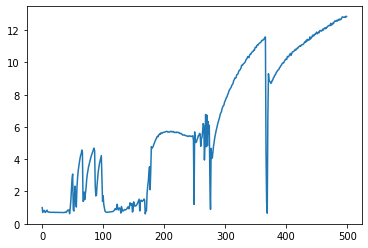

In [28]:
plt.plot(total_Gloss)

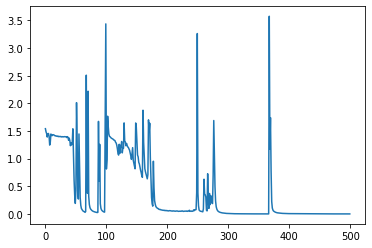

In [29]:
plt.plot(total_Dloss)

In [39]:
np.save('0612_LSTMgan_gloss.npy', np.array(total_Gloss))
np.save('0612_LSTMgan_dis_dloss.npy',np.array(total_Dloss ))

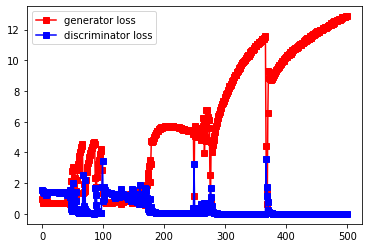

In [40]:
import matplotlib.pyplot as plt
g = np.load('0612_LSTMgan_gloss.npy')
month = [i for i in range(len(g))]
plt.plot(g,'s-',color = 'r', label="generator loss")
d=np.load('0612_LSTMgan_dis_dloss.npy')
plt.plot(d,'s-',color = 'b', label="discriminator loss")
plt.legend(loc = "best", fontsize=10)
plt.show()